In [7]:
# Here are a set of libraries we imported to complete this assignment. 
# Feel free to use these or equivalent libraries for your implementation
# If you can run this cell without any errors, you're ready to go.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import GaussianNB


# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold


import os
import itertools
import random 

%matplotlib inline

random.seed(148) 

# from tsfresh import extract_features

In [8]:
# make it dark mode (delete it later)
# !jt -l
# jt -l

In [9]:
#!jt -t <theme name>
#!jt -t chesterish
#jt -t chesterish

In [10]:
#Enable the toolbar: !jt -t [theme name] -T

In [11]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [12]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

1. Merge Datasets and Effectively Link information - Useful information for this project will come from disparate datasets. You will need to effectively merge them into a single dataframe for analysis

Can combine:
Brand Average Retail Price
Brand total sales
Brand total units

Combine on: Brand and Month to get the columns:
Brand, Month:
    ARP, vs Prior Period (Average Retail Price), Total Sales (total sales), Total Units, vs Prior Period (total units)

In [13]:
#data_1 = pd.read_csv('data\BrandAverageRetailPrice.csv')
#data_2 = pd.read_csv('data\BrandDetails.csv')
#data_3 = pd.read_csv('data\BrandTotalSales.csv')
#data_4 = pd.read_csv('data\BrandTotalUnits.csv')

#combine based on brand
#https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html
#df3 = pd.merge(df1, df2)
#combine_1 = pd.merge(data_1, data_2)
#combine_2 = pd.merge(data_3, data_4)
#data = pd.merge(combine_1, combine_2)

#to check all of data
#data.to_csv('total_combine_data.csv', index=False)

In [14]:
#the , in the thousands space makes the columns an object
#data_1
brand_average_retail_price = pd.read_csv('data\BrandAverageRetailPrice.csv', thousands=",")
#data_2
brand_details = pd.read_csv('data\BrandDetails.csv')
#data_3
brand_total_sales = pd.read_csv('data\BrandTotalSales.csv', thousands=",")
#data_4
brand_total_units = pd.read_csv('data\BrandTotalUnits.csv', thousands=",")
#Need to rename prior period as it is not being added onto, they are being combined (in 1 and 4)
#data_4
brand_total_units = brand_total_units.rename(columns={"vs. Prior Period": "vs Prior Period unit"})

#combine based on brand
#https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html
#df3 = pd.merge(df1, df2)
#Need outer join to keep every month
#Difference between price and unit # in prior period
combine_1 = pd.merge(brand_average_retail_price, brand_total_units, how='left', suffixes=('_apr', '_units'))
#combine_2 = pd.merge(data_3, data_4)
data_per_month = pd.merge(combine_1, brand_total_sales, left_on = ['Brands', 'Months'], right_on = ['Brand', 'Months'], how= 'left', \
                          suffixes=(False, '_total_sales'))

#brand got copied over onto another column, need to delete that
del data_per_month['Brand']


#So first issue is the data in its current form isn't really useful to us, 
#so let's do some conversion of our data.
#First convert our months to datetime
#data_per_month['Months'] = pd.to_datetime(data_per_month['Months'])
# #Total units is too large currently to convert to a float
# #need to trim it first then convert to float
# data_per_month['Total Units'] = data_per_month['Total Units'].str[8:]
# data_per_month['Total Units'] = pd.to_numeric(data_per_month['Total Units'])


data_per_month.info()

#to check all of data
data_per_month.to_csv('data_per_month.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27211 entries, 0 to 27210
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brands                27211 non-null  object 
 1   Months                27211 non-null  object 
 2   ARP                   25279 non-null  float64
 3   vs. Prior Period      24499 non-null  float64
 4   Total Units           25279 non-null  float64
 5   vs Prior Period unit  24893 non-null  float64
 6   Total Sales ($)       25279 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.7+ MB


Need to handle BrandDetails differents as it only tracks their items and their price and then details the Total Sales, Total Units, ARP

Note for later: flavor, is flavored == Null, ask later

In [15]:
#Do later as it does not fit at the moment

In [16]:
#Head Method
data_per_month.head()
#arp is average retail price

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($)
0,#BlackSeries,08/2020,15.684913,NaN,1616.339004,NaN,25352.135918
1,#BlackSeries,09/2020,NaN,-1.000000,NaN,-1.000000,NaN
2,#BlackSeries,01/2021,13.611428,NaN,715.532838,NaN,9739.423400
3,#BlackSeries,02/2021,11.873182,-0.127705,766.669135,0.071466,9102.802187
4,#BlackSeries,03/2021,NaN,-1.000000,NaN,-1.000000,NaN


In [17]:
#Describe Method
data_per_month.describe()

,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($)
count,25279.000000,24499.000000,2.527900e+04,24893.000000,2.527900e+04
mean,22.679732,-0.065028,2.886210e+04,0.267441,4.093729e+05
std,19.802724,0.388923,1.617156e+05,3.293738,1.596024e+06
min,0.000000,-1.000000,3.842953e+00,-1.000000,0.000000e+00
25%,10.512827,-0.088073,7.169135e+02,-0.349745,1.390320e+04
50%,17.033051,-0.011649,3.605059e+03,-0.054400,6.210080e+04
75%,31.505612,0.045232,1.564044e+04,0.241073,2.473270e+05
max,700.874984,12.645741,5.248082e+06,250.792020,4.036351e+07


In [18]:
#Info method
data_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27211 entries, 0 to 27210
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brands                27211 non-null  object 
 1   Months                27211 non-null  object 
 2   ARP                   25279 non-null  float64
 3   vs. Prior Period      24499 non-null  float64
 4   Total Units           25279 non-null  float64
 5   vs Prior Period unit  24893 non-null  float64
 6   Total Sales ($)       25279 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.7+ MB


2. Develop basic Time Series Feature Extraction Plan - develop a series of standard timeseries features to augment your dataset and enable timeseries predictive models.

In [19]:
#Dropping all row with nulls in total sales:
#df = df.dropna(how='any',axis=0)
#data_per_month = data_per_month.dropna(how = 'any', axis = 0)
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
#data_per_month = data_per_month.dropna(axis = 0, subset = ['Total Sales ($)'])
#df.dropna(subset=['TotalMarks'])
data_per_month_no_nulls = data_per_month.dropna(subset = ['Total Sales ($)']).reset_index()
data_per_month_no_nulls.to_csv('data_per_month_no_nulls.csv', index=False)

In [20]:
#Need to split the data before we add on the features:
#Everything but the last month of a brand = train
#Last month of each brand = test

#only input the averages into the training set not the test set
#as to not leak values from the test to train and get overfitting

#https://stackoverflow.com/questions/36923494/pandas-dataframe-use-previous-row-value-for-complicated-if-conditions-to-deter

test_data = []
train_data = []

d = {'Brands': [], 'Months': [], 'ARP': [], 'vs. Prior Period': [], 'Total Units': [], 'vs Prior Period unit': [], 'Total Sales ($)': []}
test_data = pd.DataFrame(data=d)
train_data = pd.DataFrame(data=d)

# print(test_data)
# print(train_data)
# print(data_per_month)

# where_null_values = pd.isnull(data_per_month)
# where_null_values
# where_null_values.to_csv('where_null_values.csv', index=False)

for index, row in data_per_month_no_nulls.iterrows():
    #row = dict containing all data for that row, not row number
    #that would be index
    next_row = index + 1
    #need .iloc
    if (next_row >= len(data_per_month_no_nulls)):
        #Need to check to see if any of the items are null, if they are, add in the averges
        
        test_data = test_data.append(data_per_month_no_nulls.iloc[index])
    elif (data_per_month_no_nulls.iloc[next_row]['Brands'] != data_per_month_no_nulls.iloc[index]['Brands']):
        test_data = test_data.append(data_per_month_no_nulls.iloc[index])
    else:
        train_data = train_data.append(data_per_month_no_nulls.iloc[index])

#print(train_data)
#print(test_data)
#to check all of data
train_data.to_csv('train_data_per_month.csv', index=False)
test_data.to_csv('test_data_per_month.csv', index=False)

In [21]:
#Now, need to add in missing values to test data
#Columns:
#0: Brand
#1: Months
#2: ARP
#3: vs. Prior Period
#4: Total Units
#5: vs Prior Period unit
#6: Total Sales ($)

#Need the () for copy!!
filled_in_test_data = test_data.copy().reset_index()

# d = {'Brands': [], 'Months': [], 'ARP': [], 'vs. Prior Period': [], 'Total Units': [], 'vs Prior Period unit': [], 'Total Sales ($)': []}
# filled_in_test_data = pd.DataFrame(data=d)

#project 1

#Taking the average as it feels better

new_ARP = data_per_month["ARP"].mean()
new_vs_Prior_Period = data_per_month["vs. Prior Period"].mean()
new_total_units = data_per_month["Total Units"].mean()
new_vs_unit = data_per_month["vs Prior Period unit"].mean()
new_total_sales = data_per_month["Total Sales ($)"].mean()

filled_in_test_data["ARP"].fillna(new_ARP, inplace=True)
#to replace the -1's
#Don't replace the -1's!!!
#filled_in_test_data["ARP"].replace({-1: new_ARP}, inplace=True)

filled_in_test_data["vs. Prior Period"].fillna(new_vs_Prior_Period, inplace=True)
#filled_in_test_data["vs. Prior Period"].replace({-1: new_vs_Prior_Period}, inplace=True)

filled_in_test_data["Total Units"].fillna(new_total_units, inplace=True)
#filled_in_test_data["Total Units"].replace({-1: new_total_units}, inplace=True)

filled_in_test_data["vs Prior Period unit"].fillna(new_vs_unit, inplace=True)
#filled_in_test_data["vs Prior Period unit"].replace({-1: new_vs_unit}, inplace=True)

filled_in_test_data["Total Sales ($)"].fillna(new_total_sales, inplace=True)
#filled_in_test_data["Total Sales ($)"].replace({-1: new_total_sales}, inplace=True)

#Need the () for copy!!
#filled_in_test_data = test_data.copy().reset_index()

# only have brands that have a final month

# test_data_clean = test_data.copy().reset_index()

# filled_in_test_data = []
# d = {'Brands': [], 'Months': [], 'ARP': [], 'vs. Prior Period': [], 'Total Units': [], 'vs Prior Period unit': [], 'Total Sales ($)': []}
# filled_in_test_data = pd.DataFrame(data=d)

# where_null_values = pd.isnull(test_data_clean)
# where_null_values
# where_null_values.to_csv('where_null_values.csv', index=False)

# for index, row in test_data_clean.iterrows():
#     if (where_null_values.iloc[index]['Total Sales ($)'] == False):
#         filled_in_test_data = filled_in_test_data.append(test_data_clean.iloc[index])
#     else:
#         stuff = 1

        
filled_in_test_data.to_csv('filled_in_test_data.csv', index=False)

In [22]:
#now add in missing values to Train data, but leave out the test data
#Columns:
#0: Brand
#1: Months
#2: ARP
#3: vs. Prior Period
#4: Total Units
#5: vs Prior Period unit
#6: Total Sales ($)

#only add in brands that are present in the test set

#Need the () for copy!!
filled_in_train_data = train_data.copy().reset_index()

# d = {'Brands': [], 'Months': [], 'ARP': [], 'vs. Prior Period': [], 'Total Units': [], 'vs Prior Period unit': [], 'Total Sales ($)': []}
# filled_in_test_data = pd.DataFrame(data=d)

#project 1

new_ARP = test_data["ARP"].mean()
new_vs_Prior_Period = test_data["vs. Prior Period"].mean()
new_total_units = test_data["Total Units"].mean()
new_vs_unit = test_data["vs Prior Period unit"].mean()
new_total_sales = test_data["Total Sales ($)"].mean()

filled_in_train_data["ARP"].fillna(new_ARP, inplace=True)
#to replace the -1's
#don't replace the -1's!!
#filled_in_train_data["ARP"].replace({-1: new_ARP}, inplace=True)

filled_in_train_data["vs. Prior Period"].fillna(new_vs_Prior_Period, inplace=True)
#filled_in_train_data["vs. Prior Period"].replace({-1: new_vs_Prior_Period}, inplace=True)

filled_in_train_data["Total Units"].fillna(new_total_units, inplace=True)
#filled_in_train_data["Total Units"].replace({-1: new_total_units}, inplace=True)

filled_in_train_data["vs Prior Period unit"].fillna(new_vs_unit, inplace=True)
#filled_in_train_data["vs Prior Period unit"].replace({-1: new_vs_unit}, inplace=True)

filled_in_train_data["Total Sales ($)"].fillna(new_total_sales, inplace=True)
#filled_in_train_data["Total Sales ($)"].replace({-1: new_total_sales}, inplace=True)

        
filled_in_train_data.to_csv('filled_in_train_data.csv', index=False)

Last months, 
Last quarter's, 
Last year's average

In [23]:
# Austyn
# #Last months
# #Last quarter's 
# #Last year's average

# #Last months:
# months = ['Jan', 'Feb', 'March', 'Apr', "May", 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
# months_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# #augmenting based on vs Prior Period
# #For total sales: divd based on Total Units or ARP, figure out later
# #For each row, 
# #if the row above does not have a month prior, add in a month 
# #add in a check like a column that sayss added in and mark it yes

# #New dataset
additional_month_train = []

d = {'Brands': [], 'Months': [], 'ARP': [], 'vs. Prior Period': [], 'Total Units': [], 'vs Prior Period unit': [], 'Total Sales ($)': []}
additional_month_train = pd.DataFrame(data=d)

#train_filled_in_copy = filled_in_train_data.copy().reset_index()
train_filled_in_copy = filled_in_train_data.copy()

for row, index in train_filled_in_copy.iterrows():
    #index = dict containing all data for that row, 
    #not row number that would be row
#     print("row is: ")
#     print(row)
#     print("index is")
#     print(index)
#     print("index [1] is")
#     print(index[1])
#     print("index[1][0] is")
#     print(index[0][1])
#     print("index[0][1] is")
#     print(index[1][0])
#     print("index[Month] is:")
#     print(index["Months"])
#     #Need string for columns, not indiviual cells
#     print("index[Months].split('/') is")
#     print(index["Months"].split('/'))
#     broken_apart_month = index["Months"].split('/')
#     print(broken_apart_month[0])
#     print(broken_apart_month[1])
    
    
    prev_row = row - 1
    #need .iloc
    if (prev_row < 0):
        # print("Previous row is 0")
        # Need to check to see if any of the items are null, if they are, add in the averges
        # 0th row (the month we are adding before the first row in the dataset)
        new_brand = train_filled_in_copy.iloc[0]['Brands']
        broken_apart_month = index["Months"].split('/')
        previous_month = str(int(broken_apart_month[0])- 1)
        # print("before_previous_month")
        # print(previous_month)
        year = broken_apart_month[1]
        #print(year)
        previous_month_int = int(broken_apart_month[0])- 1
        if (previous_month_int == 0):
            previous_month = str(12)
            year = str(int(broken_apart_month[1]) - 1)
        combined_previous_month = previous_month + "/" + year
        # print(combined_previous_month)
        
#         #Testing for 2nd if
#         #Working good
#         print("Month 1 line:")
#         month_num = int(train_filled_in_copy.iloc[0]['Months'].split('/')[0])
#         print(month_num)
#         print(type(month_num))
#         print("Month string")
#         month_string = str(train_filled_in_copy.iloc[0]['Months'].split('/')[0])
#         print(month_string)
#         print(type(month_string))
        
#         if(int(train_filled_in_copy.iloc[0]['Months'].split('/')[0]) == 
#            int(train_filled_in_copy.iloc[0]['Months'].split('/')[0])):
#             print("True, test passed")
#         else:
#             print("Test Failed")
        
        
        original_arp = float(index["ARP"])
        #print("Original arp is")
        #print(original_arp)
        #new_vs_Prior_Period = data_per_month["vs. Prior Period"].mean()
        new_vs_prior_period = data_per_month["vs. Prior Period"].mean()
        #print("old prior period is")
        #print(index["vs. Prior Period"])
        how_much_new = float(original_arp) * float(index["vs. Prior Period"])
        #print("how much new")
        #print(how_much_new)
        before_arp_int = float(original_arp) + float(how_much_new)
        new_arp = before_arp_int
        #print("new_arp")
        #print(new_arp)
        
        
        original_total_units = float(index["Total Units"])
        new_prior_units = data_per_month["vs Prior Period unit"].mean()
        how_much_new = float(original_total_units) * float(index["vs Prior Period unit"])
        new_total_units_int = float(original_total_units) + float(how_much_new)
        new_total_units = new_total_units_int
        
        
        new_total_sales = new_arp * new_total_units
        
        #new_vs_unit = data_per_month["vs Prior Period unit"].mean()
#         a_row = pd.Series([new_brand,
#                            combined_previous_month,
#                            new_arp, 
#                            new_vs_prior_period, 
#                            new_total_units,
#                            new_prior_units,
#                            new_total_sales])
        a_dict = {'Brands': new_brand, 
                  'Months': combined_previous_month, 
                  'ARP': new_arp, 
                  'vs. Prior Period': new_vs_prior_period, 
                  'Total Units': new_total_units, 
                  'vs Prior Period unit': new_prior_units, 
                  'Total Sales ($)': new_total_sales
                 }
        row_df = pd.DataFrame([a_dict])
        additional_month_train = additional_month_train.append(row_df, ignore_index=True)
        #supposed to be:
        #Brand: #Black Series
        #Months: 7/2020
        #ARP: 6.75
        #vs. Prior Period: 
        #Total Units: 934
        #vs Prior Period unit:
        #Total Sales ($): 6304.5
#         print("New row values are:")
#         print("Brand is:")
#         print(new_brand)
#         print("New month is")
#         print(combined_previous_month)
#         print("ARP is")
#         print(new_arp)
#         print("new prior period is")
#         print(new_vs_prior_period)
#         print("new total units is")
#         print(new_total_units)
#         print("New prior units are:")
#         print(new_prior_units)
#         print("new total sales are")
#         print(new_total_sales)
        #1st row
        
        original_brand = index["Brands"]
        original_months = index["Months"]
        original_arp = index["ARP"]
        original_vs_prior = index["vs. Prior Period"]
        original_total_unit = index["Total Units"]
        original_prior_units = index["vs Prior Period unit"]
        original_sales = index["Total Sales ($)"]
#         b_row = pd.Series([original_brand,
#                            original_months,
#                            original_arp, 
#                            original_vs_prior, 
#                            original_total_unit,
#                            original_prior_units,
#                            original_sales])
        b_dict = {'Brands': original_brand, 
                  'Months': original_months, 
                  'ARP': original_arp, 
                  'vs. Prior Period': original_vs_prior, 
                  'Total Units': original_total_unit, 
                  'vs Prior Period unit': original_prior_units, 
                  'Total Sales ($)': original_sales}
        b_row_df = pd.DataFrame([b_dict])
        additional_month_train = additional_month_train.append(b_row_df, ignore_index=True)
#         print("Original row is:")
#         print(train_filled_in_copy.iloc[row])
        
        #print("---------------------------------------------------------------------------")
        
        
    #If the previous entry does not have the same brand or the months are not 1 apart
    #data_per_month.iloc[next_row]['Brands'] != data_per_month.iloc[index]['Brands']
#     (str(additional_month_train.iloc[-1]['Brands']) !=
#           str(train_filled_in_copy.iloc[row]['Brands'])) or 
    elif ((str(additional_month_train.iloc[-1]['Brands']) ==
          str(train_filled_in_copy.iloc[row]['Brands'])) and 
          (int(additional_month_train.iloc[-1]['Months'].split('/')[0]) != 
           int(train_filled_in_copy.iloc[row]['Months'].split('/')[0]) - 1)):
        
        if(int(train_filled_in_copy.iloc[row]['Months'].split('/')[0]) - 1 == 0 and
           int(additional_month_train.iloc[-1]['Months'].split('/')[0]) == 12):
            continue
        
        new_brand = filled_in_train_data.iloc[row]['Brands']
        broken_apart_month = index["Months"].split('/')
        previous_month = str(int(broken_apart_month[0])- 1)
        previous_month_int = int(broken_apart_month[0])- 1
        year = broken_apart_month[1]
        if (previous_month_int == 0):
            previous_month = str(12)
            year = str(int(broken_apart_month[1]) - 1)
        combined_previous_month = previous_month + "/" + year
        #print(combined_previous_month)
        original_arp = float(index["ARP"])
        new_vs_prior_period = data_per_month["vs. Prior Period"].mean()
        how_much_new = float(original_arp) * float(index["vs. Prior Period"])
        before_arp_int = float(original_arp) + float(how_much_new)
        new_arp = before_arp_int
        original_total_units = float(index["Total Units"])
        new_prior_units = data_per_month["vs Prior Period unit"].mean()
        how_much_new = float(original_total_units) * float(index["vs Prior Period unit"])
        new_total_units_int = float(original_total_units) + float(how_much_new)
        new_total_units = new_total_units_int
        new_total_sales = new_arp * new_total_units
        #new_vs_unit = data_per_month["vs Prior Period unit"].mean()
#         a_row = pd.Series([new_brand,
#                            combined_previous_month,
#                            new_arp, 
#                            new_vs_prior_period, 
#                            new_total_units,
#                            new_prior_units,
#                            new_total_sales])
#         row_df = pd.DataFrame([a_row])
        a_dict = {'Brands': new_brand, 
                  'Months': combined_previous_month, 
                  'ARP': new_arp, 
                  'vs. Prior Period': new_vs_prior_period, 
                  'Total Units': new_total_units, 
                  'vs Prior Period unit': new_prior_units, 
                  'Total Sales ($)': new_total_sales}
        row_df = pd.DataFrame([a_dict])
        additional_month_train = additional_month_train.append(row_df, ignore_index=True)
        
        original_brand = index["Brands"]
        original_months = index["Months"]
        original_arp = index["ARP"]
        original_vs_prior = index["vs. Prior Period"]
        original_total_unit = index["Total Units"]
        original_prior_units = index["vs Prior Period unit"]
        original_sales = index["Total Sales ($)"]
        
#         b_row = pd.Series([original_brand,
#                            original_months,
#                            original_arp, 
#                            original_vs_prior, 
#                            original_total_unit,
#                            original_prior_units,
#                            original_sales])
#         b_row_df = pd.DataFrame([b_row])
        b_dict = {'Brands': original_brand, 
                  'Months': original_months, 
                  'ARP': original_arp, 
                  'vs. Prior Period': original_vs_prior, 
                  'Total Units': original_total_unit, 
                  'vs Prior Period unit': original_prior_units, 
                  'Total Sales ($)': original_sales}
        b_row_df = pd.DataFrame([b_dict])
        additional_month_train = additional_month_train.append(b_row_df, ignore_index=True)
        
#         print("New row values are:")
#         print("Brand is:")
#         print(new_brand)
#         print("New month is")
#         print(combined_previous_month)
#         print("ARP is")
#         print(new_arp)
#         print("new prior period is")
#         print(new_vs_prior_period)
#         print("new total units is")
#         print(new_total_units)
#         print("New prior units are:")
#         print(new_prior_units)
#         print("new total sales are")
#         print(new_total_sales)
        
#         print("Original row is:")
#         print(additional_month_train)
        
#         print("---------------------------------------------------------------------------")
        
        
#     #If the previous entry is not the same brand
#     elif(data_per_month.iloc[next_row]['Brands'] != train_data.iloc[index]['Brands']):
#         new_brand = filled_in_train_data.iloc[index]['Brands']
#         broken_apart_month = index["Months"].split('/')
#         previous_month = str(int(broken_apart_month[0])- 1)
#         year = broken_apart_month[1]
#         if (previous_month == 0):
#             previous_month = str(12)
#             year = str(int(broken_apart_month[1]) - 1)
#         combined_previous_month = previous_month + "/" + year
#         original_arp = float(index["ARP"])
#         new_vs_prior_period = data_per_month["vs. Prior Period"].mean()
#         how_much_new = float(original_arp) * float(index["vs. Prior Period"])
#         before_arp_int = float(original_arp) + float(how_much_new)
#         new_arp = before_arp_int
#         original_total_units = float(index["Total Units"])
#         new_prior_units = data_per_month["vs Prior Period unit"].mean()
#         how_much_new = float(original_total_units) * float(index["vs Prior Period unit"])
#         new_total_units_int = float(original_total_units) + float(how_much_new)
#         new_total_units = new_total_units_int
#         new_total_sales = new_arp * new_total_units
#         #new_vs_unit = data_per_month["vs Prior Period unit"].mean()
#         additional_month_train = additional_month_train.append([new_brand,
#                                                                combined_previous_month,
#                                                                new_arp, 
#                                                                new_vs_prior_period, 
#                                                                new_total_units,
#                                                                new_prior_units,
#                                                                new_total_sales])
#         additional_month_train = additional_month_train.append(train_data.iloc[index])
    
    #need case of first entry of the brand to add in
    elif(str(additional_month_train.iloc[-1]['Brands']) !=
          str(train_filled_in_copy.iloc[row]['Brands'])):
        new_brand = filled_in_train_data.iloc[row]['Brands']
        broken_apart_month = index["Months"].split('/')
        previous_month = str(int(broken_apart_month[0])- 1)
        year = broken_apart_month[1]
        previous_month_int = int(broken_apart_month[0])- 1
        if (previous_month_int == 0):
            previous_month = str(12)
            year = str(int(broken_apart_month[1]) - 1)
        combined_previous_month = previous_month + "/" + year
        original_arp = float(index["ARP"])
        new_vs_prior_period = data_per_month["vs. Prior Period"].mean()
        how_much_new = float(original_arp) * float(index["vs. Prior Period"])
        before_arp_int = float(original_arp) + float(how_much_new)
        new_arp = before_arp_int
        original_total_units = float(index["Total Units"])
        new_prior_units = data_per_month["vs Prior Period unit"].mean()
        how_much_new = float(original_total_units) * float(index["vs Prior Period unit"])
        new_total_units_int = float(original_total_units) + float(how_much_new)
        new_total_units = new_total_units_int
        new_total_sales = new_arp * new_total_units
        a_dict = {'Brands': new_brand, 
                  'Months': combined_previous_month, 
                  'ARP': new_arp, 
                  'vs. Prior Period': new_vs_prior_period, 
                  'Total Units': new_total_units, 
                  'vs Prior Period unit': new_prior_units, 
                  'Total Sales ($)': new_total_sales
                 }
        row_df = pd.DataFrame([a_dict])
        additional_month_train = additional_month_train.append(row_df, ignore_index=True)
        original_brand = index["Brands"]
        original_months = index["Months"]
        original_arp = index["ARP"]
        original_vs_prior = index["vs. Prior Period"]
        original_total_unit = index["Total Units"]
        original_prior_units = index["vs Prior Period unit"]
        original_sales = index["Total Sales ($)"]
        b_dict = {'Brands': original_brand, 
                  'Months': original_months, 
                  'ARP': original_arp, 
                  'vs. Prior Period': original_vs_prior, 
                  'Total Units': original_total_unit, 
                  'vs Prior Period unit': original_prior_units, 
                  'Total Sales ($)': original_sales}
        b_row_df = pd.DataFrame([b_dict])
        additional_month_train = additional_month_train.append(b_row_df, ignore_index=True)
        
        
    #Easy case, when the previous row has the same brand, and the month is one back
    else:
        original_brand = index["Brands"]
        original_months = index["Months"]
        original_arp = index["ARP"]
        original_vs_prior = index["vs. Prior Period"]
        original_total_unit = index["Total Units"]
        original_prior_units = index["vs Prior Period unit"]
        original_sales = index["Total Sales ($)"]
        
#         b_row = pd.Series([original_brand,
#                            original_months,
#                            original_arp, 
#                            original_vs_prior, 
#                            original_total_unit,
#                            original_prior_units,
#                            original_sales])
#         b_row_df = pd.DataFrame([b_row])
        b_dict = {'Brands': original_brand, 
                  'Months': original_months, 
                  'ARP': original_arp, 
                  'vs. Prior Period': original_vs_prior, 
                  'Total Units': original_total_unit, 
                  'vs Prior Period unit': original_prior_units, 
                  'Total Sales ($)': original_sales}
        b_row_df = pd.DataFrame([b_dict])
        additional_month_train = additional_month_train.append(b_row_df, ignore_index=True)
        
#         print("Original row is:")
#         print(additional_month_train)
#         print("---------------------------------------------------------------------------")


#to check all of data
additional_month_train.to_csv('additional_month_train.csv', index=False)

In [24]:
#train_copy = train_data.copy().reset_index()
# train_copy.dropna(subset=['Months'], inplace=True)
data_per_month['Months'] = pd.to_datetime(data_per_month['Months'])

In [25]:
# https://www.geeksforgeeks.org/split-a-text-column-into-two-columns-in-pandas-dataframe/
# train_data.Months.str.split('/')[1]
# train_copy['month'], train_copy['year'] = pd.DataFrame(train_data.Months.str.split('/',1).tolist(), columns = ['month', 'year'])
# train_copy
#train_2 = pd.DataFrame(train_data.Months.str.split('/', 1).tolist(), columns = ['month', 'year'])
additional_month_train['month'] = pd.DatetimeIndex(additional_month_train['Months']).month
additional_month_train['year'] = pd.DatetimeIndex(additional_month_train['Months']).year
additional_month_train

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019
...,...,...,...,...,...,...,...,...,...
25987,Zoma,07/2020,7.532381,0.026479,1663.536810,0.169739,12530.392238,7,2020
25988,Zuma Topicals,7/2019,32.434901,-0.065028,365.561457,0.267441,11856.949543,7,2019
25989,Zuma Topicals,08/2019,31.598214,0.026479,312.515336,0.169739,9874.926545,8,2019
25990,Zuma Topicals,09/2019,37.860964,0.198199,464.306316,0.485707,17579.084649,9,2019


In [26]:
annual_avg_add = additional_month_train.copy()

annual_avg_add.dropna(subset=['ARP'], inplace=True)
if 'index' in annual_avg_add.columns:
    annual_avg_add.drop(['index'], axis=1, inplace=True)

# yearly average: count brands and year, then add sum of ARP, then divide
grouped = annual_avg_add.groupby(['Brands', 'year'])
annual_avg_add['annual_avg'] = grouped['ARP'].transform('sum') / grouped['Brands'].transform('count')
annual_avg_add.to_csv('annual_avg_add.csv', index=False)
annual_avg_add

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389
...,...,...,...,...,...,...,...,...,...,...
25987,Zoma,07/2020,7.532381,0.026479,1663.536810,0.169739,12530.392238,7,2020,7.632105
25988,Zuma Topicals,7/2019,32.434901,-0.065028,365.561457,0.267441,11856.949543,7,2019,34.110058
25989,Zuma Topicals,08/2019,31.598214,0.026479,312.515336,0.169739,9874.926545,8,2019,34.110058
25990,Zuma Topicals,09/2019,37.860964,0.198199,464.306316,0.485707,17579.084649,9,2019,34.110058


In [27]:
#yearly average for each brand
#split
#yearly average
#Total sales for each brand

#1 row of data for each data point, each row has all info
#Data, all necessary info in one row
# multiple data training point for 1 branch, mulitple data branch
#For each brand

#overall data also: seasonalities

In [28]:
# #rolling_df = additional_month_train.copy()
# # Define a custom function which groups by time (using the index)
# rolling_average_percent_change = additional_month_train.copy()
# rolling_df = additional_month_train.copy()

# rolling_average_percent_change = rolling_df.assign(moving_score=rolling_df.groupby(['Brands'], as_index=False)[['Total Sales ($)']]
#                            .rolling(720, min_periods=0).mean().fillna(0)
#                            .reset_index(0, drop=True))
# #additional_month_train.head(50)

# rolling_average_percent_change["prcnt chng"] = rolling_average_percent_change["Total Sales ($)"].pct_change(1)
# rolling_average_percent_change.to_csv('rolling_average_percent_change.csv', index=False)

In [29]:
#Add in a rolling average

In [30]:
#rolling_df = additional_month_train.copy()
# Define a custom function which groups by time (using the index)
rolling_average_percent_change = annual_avg_add.copy()
#rolling_df = annual_avg_add.copy()

#rolling_average_percent_change = rolling_average_percent_change.assign(rolling_average_units=rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Units']].rolling(720, min_periods=0).mean().fillna(0).reset_index(0, drop=True))
rolling_average_percent_change = rolling_average_percent_change.assign(rolling_average_units=rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Units']]
                                                                       .rolling(720, min_periods=0)
                                                                       .mean()
                                                                       #.fillna(0)
                                                                       .reset_index(0, drop=True)
                                                                      )



#rolling_average_percent_change["percent change units"] = rolling_average_percent_change["Total Units"].pct_change(1)
rolling_average_percent_change = rolling_average_percent_change.assign(percent_change_units = rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Units']].pct_change(1))

#rolling_df = annual_avg_add.copy()

rolling_average_percent_change = rolling_average_percent_change.assign(rolling_average_sales=rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Sales ($)']].rolling(720, min_periods=0).mean().fillna(0).reset_index(0, drop=True))
#additional_month_train.head(50)

#rolling_average_percent_change["percent change sales"] = rolling_average_percent_change["Total Sales ($)"].pct_change(1)
rolling_average_percent_change = rolling_average_percent_change.assign(percent_change_sales = rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Sales ($)']].pct_change(1))


#Filling null's with 0's:
rolling_average_percent_change['rolling_average_units'] = rolling_average_percent_change['rolling_average_units'].fillna(0)
rolling_average_percent_change['percent_change_units'] = rolling_average_percent_change['percent_change_units'].fillna(0)
rolling_average_percent_change['rolling_average_sales'] = rolling_average_percent_change['rolling_average_sales'].fillna(0)
rolling_average_percent_change['percent_change_sales'] = rolling_average_percent_change['percent_change_sales'].fillna(0)



rolling_average_percent_change.to_csv('rolling_average_percent_change.csv', index=False)

rolling_average_percent_change

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,rolling_average_units,percent_change_units,rolling_average_sales,percent_change_sales
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329,1890.695184,0.000000,30440.631130,0.000000
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329,1753.517094,-0.145109,27896.383524,-0.167161
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329,1448.007012,-0.482171,22495.672082,-0.538727
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428,1264.888469,-0.145109,19306.609912,-0.167161
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389,153.315057,0.000000,5361.230542,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25987,Zoma,07/2020,7.532381,0.026479,1663.536810,0.169739,12530.392238,7,2020,7.632105,6704.835010,-0.145109,73423.955391,-0.167161
25988,Zuma Topicals,7/2019,32.434901,-0.065028,365.561457,0.267441,11856.949543,7,2019,34.110058,365.561457,0.000000,11856.949543,0.000000
25989,Zuma Topicals,08/2019,31.598214,0.026479,312.515336,0.169739,9874.926545,8,2019,34.110058,339.038396,-0.145109,10865.938044,-0.167161
25990,Zuma Topicals,09/2019,37.860964,0.198199,464.306316,0.485707,17579.084649,9,2019,34.110058,380.794370,0.485707,13103.653579,0.780174


In [31]:
# df = rolling_average_percent_change
# # Replace the column names as appropriate
# # Leave the column names empty
# # if you don't have them in your data
# features = extract_features(df, column_id="Brands", column_sort="Months")
# features

In [32]:
# features["ARP__median"]

In [33]:
#Need to do

#Need to add previous month column
# inserting new column with yesterday's consumption values
final_timeseries = rolling_average_percent_change.copy()
#olling_average_percent_change = rolling_average_percent_change.assign(percent_change_sales = rolling_average_percent_change.groupby(['Brands'], as_index=False)[['Total Sales ($)']].pct_change(1))
#final_timeseries.loc[:,'Previous Month'] = final_timeseries.loc[:,'Total Units'].shift(-1)
final_timeseries = final_timeseries.assign(previous_month_units = final_timeseries.groupby(['Brands'], as_index=False)[['Total Units']].shift(-1))

final_timeseries.to_csv('final_timeseries.csv', index=False)

final_timeseries

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,rolling_average_units,percent_change_units,rolling_average_sales,percent_change_sales,previous_month_units
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329,1890.695184,0.000000,30440.631130,0.000000,1616.339004
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329,1753.517094,-0.145109,27896.383524,-0.167161,836.986849
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329,1448.007012,-0.482171,22495.672082,-0.538727,715.532838
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428,1264.888469,-0.145109,19306.609912,-0.167161,NaN
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389,153.315057,0.000000,5361.230542,0.000000,131.067720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25987,Zoma,07/2020,7.532381,0.026479,1663.536810,0.169739,12530.392238,7,2020,7.632105,6704.835010,-0.145109,73423.955391,-0.167161,NaN
25988,Zuma Topicals,7/2019,32.434901,-0.065028,365.561457,0.267441,11856.949543,7,2019,34.110058,365.561457,0.000000,11856.949543,0.000000,312.515336
25989,Zuma Topicals,08/2019,31.598214,0.026479,312.515336,0.169739,9874.926545,8,2019,34.110058,339.038396,-0.145109,10865.938044,-0.167161,464.306316
25990,Zuma Topicals,09/2019,37.860964,0.198199,464.306316,0.485707,17579.084649,9,2019,34.110058,380.794370,0.485707,13103.653579,0.780174,348.057905


## Brand Features Engineering

I have a theory that it's important to determine if a company offers inhaleable and edible products as part of their product inventory so I'm going to create binary categorical features.

In [34]:
# value = 0
# value1 = 0
# value2 = 0
# value3 = 0
# value4 = 0
# value5= 0
# value6 = 0
# value7 = 0
# value8 = 0
# value9 = 0
# value10 = 0
# value11 = 0
# value12 = 0
# value13 = 0
# value14 = 0
# value15 = 0
# value16 = 0
# value17 = 0

# brand_details_copy = brand_details.copy()

# feature_engineering = final_timeseries.copy()

# if 'Inhaleables' in brand_details_copy['Category L1'].values:
#     value = 1
# if 'Edibles' in brand_details_copy['Category L1'].values:
#     value1 = 1
# if 'Flower' in brand_details_copy['Category L2'].values:
#     value2 = 1
# if 'Concentrates' in brand_details_copy['Category L2'].values:
#     value3 = 1
# if 'Pre-Rolled' in brand_details_copy['Category L2'].values:
#     value4 = 1
# if 'Topicals' in brand_details_copy['Category L2'].values:
#     value5 = 1
# if 'Edibles' in brand_details_copy['Category L2'].values:
#     value6 = 1
# # if 'Edibles' in brand_details_copy['Category L2'].values:
# #     value7 = 1
# if 'Hybrid' in brand_details_copy['Category L3'].values:
#     value8 = 1
# if 'Sativa Dominant' in brand_details_copy['Category L3'].values:
#     value9 = 1
# if 'Dabbable Concentrates' in brand_details_copy['Category L3'].values:
#     value10 = 1
# if 'Infused Pre-Rolled' in brand_details_copy['Category L3'].values:
#     value11 = 1
# if 'Pre-Rolled' in brand_details_copy['Category L3'].values:
#     value12 = 1
# if 'Wax' in brand_details_copy['Category L4'].values:
#     value13 = 1
# if 'Live Resin' in brand_details_copy['Category L4'].values:
#     value14 = 1
# if 'Rosin' in brand_details_copy['Category L4'].values:
#     value15 = 1
# if 'Vape Disposable' in brand_details_copy['Category L4'].values:
#     value16 = 1

# feature_engineering['Inhaleables'] = value
# feature_engineering['Edible'] = value1
# feature_engineering['Flower'] = value2
# feature_engineering['Concentrates'] = value3
# feature_engineering['Pre-Rolled'] = value4
# feature_engineering['Topicals'] = value5
# feature_engineering['Edibles'] = value6
# # feature_engineering['Edible'] = value7
# feature_engineering['Hybrid'] = value8
# feature_engineering['Sativa Dominant'] = value9
# feature_engineering['Dabbable Concentrates'] = value10
# feature_engineering['Infused Pre-Rolled'] = value11
# feature_engineering['Pre-Rolled'] = value12
# feature_engineering['Wax'] = value13
# feature_engineering['Live Resin'] = value14
# feature_engineering['Rosin'] = value15
# feature_engineering['Vape Disposable'] = value16

# feature_engineering.to_csv('feature_engineering_inhaleables.csv', index=False)

# feature_engineering

In [35]:
bd = pd.read_csv('data/BrandDetails.csv')
#bd.head(50)
#temp=['101 Cannabis Co.','#BlackSeries','Zuma Topicals']
temp1 = []
feature_engineering=[]
ft = pd.read_csv('./final_timeseries.csv')
brandsnew = bd['Brand'].unique()
#simple function returns ser to set values to zero for each iteration
def z():
    return 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
#loop thru the names in reverse order so when we append the order will be in the right way.
for i in reversed(brandsnew):
    #set all the values to zero
    value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16 = z()
    #extract first brand name
    br_b = bd[bd.Brand == i]
    #extract brands'first row
    br = br_b.head(1)
    #find same brand in our csv file
    bd_d = ft[ft.Brands == i]
    #get right feature for each category and assign value=1
    if 'Inhaleables' in br['Category L1'].values:
        value = 1
    if 'Edibles' in br['Category L1'].values:
        value1 = 1
    if 'Flower' in br['Category L2'].values:
        value2 = 1
    if 'Concentrates' in br['Category L2'].values:
        value3 = 1
    if 'Pre-Rolled' in br['Category L2'].values:
        value4 = 1
    if 'Topicals' in br['Category L2'].values:
        value5 = 1
    if 'Edibles' in br['Category L2'].values:
        value6 = 1
    if 'Hybrid' in br['Category L3'].values:
        value8 = 1
    if 'Sativa Dominant' in br['Category L3'].values:
        value9 = 1
    if 'Dabbable Concentrates' in br['Category L3'].values:
        value10 = 1
    if 'Infused Pre-Rolled' in br['Category L3'].values:
        value11 = 1
    if 'Pre-Rolled' in br['Category L3'].values:
        value12 = 1
    if 'Wax' in br['Category L4'].values:
        value13 = 1
    if 'Live Resin' in br['Category L4'].values:
        value14 = 1
    if 'Rosin' in br['Category L4'].values:
        value15 = 1
    if 'Vape Disposable' in br['Category L4'].values:
        value16 = 1
    #create column in our csv file and assign one hot coded feature
    bd_d['Inhaleables'] = value
    bd_d['Edible'] = value1
    bd_d['Flower'] = value2
    bd_d['Concentrates'] = value3
    bd_d['Pre-Rolled'] = value4
    bd_d['Topicals'] = value5
    bd_d['Edibles'] = value6
    bd_d['Hybrid'] = value8
    bd_d['Sativa Dominant'] = value9
    bd_d['Dabbable Concentrates'] = value10
    bd_d['Infused Pre-Rolled'] = value11
    bd_d['Pre-Rolled'] = value12
    bd_d['Wax'] = value13
    bd_d['Live Resin'] = value14
    bd_d['Rosin'] = value15
    bd_d['Vape Disposable'] = value16
    #append each brand page into whole csv
    temp1 = bd_d.append(temp1)
feature_engineering = temp1.copy()
feature_engineering.to_csv('feature_engineering.csv', index=True)
feature_engineering

<ipython-input-35-3ed8089527b8>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd_d['Inhaleables'] = value
<ipython-input-35-3ed8089527b8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd_d['Edible'] = value1
<ipython-input-35-3ed8089527b8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,...,Topicals,Edibles,Hybrid,Sativa Dominant,Dabbable Concentrates,Infused Pre-Rolled,Wax,Live Resin,Rosin,Vape Disposable
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329,...,0,0,1,0,0,0,0,0,0,0
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329,...,0,0,1,0,0,0,0,0,0,0
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329,...,0,0,1,0,0,0,0,0,0,0
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428,...,0,0,1,0,0,0,0,0,0,0
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25969,Zkittlez,02/2021,63.085497,0.074425,61.006881,-0.629301,3848.649409,2,2021,48.060765,...,0,0,0,0,1,0,0,1,0,0
25970,Zkittlez,03/2021,39.352005,-0.376212,768.497040,11.596891,30241.899130,3,2021,48.060765,...,0,0,0,0,1,0,0,1,0,0
25971,Zkittlez,04/2021,39.387355,0.000898,893.917749,0.163203,35209.055568,4,2021,48.060765,...,0,0,0,0,1,0,0,1,0,0
25972,Zkittlez,05/2021,40.463240,0.027316,618.015240,-0.308644,25006.899159,5,2021,48.060765,...,0,0,0,0,1,0,0,1,0,0


I also believe that a total count of the number of products the brand offers is also a useful feature to include. Fortunately that's easy enough to determine!

In [36]:
productcount = (brand_details.Brand == '101 Cannabis Co.').count()

productcount

144977

In [37]:
rolling_average_percent_change['ProdCount'] = productcount

rolling_average_percent_change.head()

,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,rolling_average_units,percent_change_units,rolling_average_sales,percent_change_sales,ProdCount
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329,1890.695184,0.000000,30440.631130,0.000000,144977
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329,1753.517094,-0.145109,27896.383524,-0.167161,144977
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329,1448.007012,-0.482171,22495.672082,-0.538727,144977
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428,1264.888469,-0.145109,19306.609912,-0.167161,144977
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389,153.315057,0.000000,5361.230542,0.000000,144977


The result is starting to look like a pretty darn good dataframe! We now have merged and engineered timeseries features, along with brand-level features included in our dataframe. 

To complete this work the next steps will be to: 

1. finalize our feature selection plan
2. consolidate these steps into a concise 'for loop' for all brands and then append them into a single dataframe
3. finalize an imputation strategy
4. You can then treat the dataset like a typical regression problem where 'TotalSales' or 'TotalUnits' can be the label you predict on
5. As always report your metrics! (and speaking of metrics, I found this handy-dandy helper function that spits out a bunch of useful ones for you...)

3. Run some basic statistics on your variables including correlations with labels and report findings - Particularly once you employ PCA and other ‘black box’ methods, the descriptive power of any of your features will effectively disappear. Still you want to report out meaningful correlations toCookies to help them flag key indicators they can employ (this step will also be helpful for you in flagging potential co-linearities).

In [38]:
#correlation matrix: enough
corr_matrix = feature_engineering.corr()
#visualize data if there is some nonlinear relationships between features

corr_matrix

,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,rolling_average_units,percent_change_units,...,Topicals,Edibles,Hybrid,Sativa Dominant,Dabbable Concentrates,Infused Pre-Rolled,Wax,Live Resin,Rosin,Vape Disposable
ARP,1.000000,0.076569,-0.074945,-0.028343,-0.007945,0.007573,-0.079630,0.954147,-0.061896,-0.016812,...,0.162548,-0.056454,-0.217493,-0.022073,0.125472,-0.019737,-0.011440,0.076926,0.095260,0.024882
vs. Prior Period,0.076569,1.000000,-0.011034,-0.097001,-0.011366,0.021451,0.001650,0.004619,-0.004456,-0.022318,...,-0.001588,-0.014499,-0.007037,0.002561,0.006417,0.008884,0.004601,0.000678,0.004485,-0.007170
Total Units,-0.074945,-0.011034,1.000000,-0.008955,0.875663,0.003014,-0.018084,-0.076941,0.977157,0.012404,...,-0.037279,-0.037870,0.099607,0.000538,-0.027942,-0.010579,-0.020575,-0.005758,-0.001396,0.027913
vs Prior Period unit,-0.028343,-0.097001,-0.008955,1.000000,-0.017775,0.003832,-0.016390,-0.014142,-0.012126,0.161914,...,-0.013128,-0.009868,0.034238,-0.003543,0.000190,-0.000963,0.009506,-0.001805,0.006155,-0.008631
Total Sales ($),-0.007945,-0.011366,0.875663,-0.017775,1.000000,0.005884,-0.036671,-0.008579,0.836630,0.008589,...,-0.048545,-0.039016,0.037797,0.007279,0.003353,0.003299,-0.028419,0.031790,0.014115,0.018664
month,0.007573,0.021451,0.003014,0.003832,0.005884,1.000000,-0.407321,0.025633,0.002850,-0.025596,...,0.006896,0.001944,-0.011570,0.003599,-0.002821,0.000387,-0.003584,0.000842,-0.002591,-0.000665
year,-0.079630,0.001650,-0.018084,-0.016390,-0.036671,-0.407321,1.000000,-0.083457,-0.026421,0.006155,...,-0.042953,0.006060,0.070971,-0.013208,0.027966,-0.018079,0.016818,0.009127,0.028000,0.000683
annual_avg,0.954147,0.004619,-0.076941,-0.014142,-0.008579,0.025633,-0.083457,1.000000,-0.064641,-0.014483,...,0.170360,-0.059167,-0.227945,-0.023133,0.131502,-0.020685,-0.011990,0.080623,0.099838,0.026078
rolling_average_units,-0.061896,-0.004456,0.977157,-0.012126,0.836630,0.002850,-0.026421,-0.064641,1.000000,-0.004475,...,-0.031985,-0.033576,0.097308,0.005048,-0.031717,-0.013364,-0.017729,-0.014477,-0.001755,0.009981
percent_change_units,-0.016812,-0.022318,0.012404,0.161914,0.008589,-0.025596,0.006155,-0.014483,-0.004475,1.000000,...,-0.007494,-0.010349,0.015659,-0.002445,0.003265,-0.001444,0.023019,-0.002973,-0.000020,-0.004843


<AxesSubplot:>

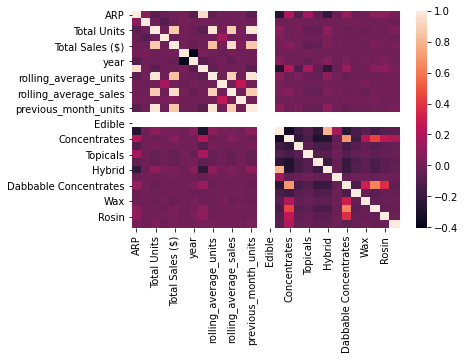

In [39]:
sns.heatmap(corr_matrix)

Implementing the PCA method

In [59]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

new_train_data = rolling_average_percent_change.iloc[:,2:-2]
pca.fit(new_train_data)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.97177675 0.02620734 0.00196411]
[3.51968760e+08 5.78006005e+07 1.58235243e+07]


In [61]:
for column in rolling_average_percent_change.columns:
    print(rolling_average_percent_change[column].max())
rolling_average_percent_change.head()

iKrusher
9/2020
700.874984361389
12.6457412457553
5248081.65022816
250.792019626486
40363507.5872179
12
2021
429.59941354089125
4905065.495191747
1503.270031307811
40001951.913019456
inf
144977


,Brands,Months,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),month,year,annual_avg,rolling_average_units,percent_change_units,rolling_average_sales,percent_change_sales,ProdCount
0,#BlackSeries,7/2020,16.100232,-0.065028,1890.695184,0.267441,30440.631130,7,2020,15.252329,1890.695184,0.000000,30440.631130,0.000000,144977
1,#BlackSeries,08/2020,15.684913,0.026479,1616.339004,0.169739,25352.135918,8,2020,15.252329,1753.517094,-0.145109,27896.383524,-0.167161,144977
2,#BlackSeries,12/2020,13.971843,-0.065028,836.986849,0.267441,11694.249199,12,2020,15.252329,1448.007012,-0.482171,22495.672082,-0.538727,144977
3,#BlackSeries,01/2021,13.611428,0.026479,715.532838,0.169739,9739.423400,1,2021,13.611428,1264.888469,-0.145109,19306.609912,-0.167161,144977
4,101 Cannabis Co.,10/2019,34.968715,-0.065028,153.315057,0.267441,5361.230542,10,2019,34.691389,153.315057,0.000000,5361.230542,0.000000,144977


In [62]:
feature_engineering.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22067 entries, 0 to 25973
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brands                 22067 non-null  object 
 1   Months                 22067 non-null  object 
 2   ARP                    22067 non-null  float64
 3   vs. Prior Period       22067 non-null  float64
 4   Total Units            22067 non-null  float64
 5   vs Prior Period unit   22067 non-null  float64
 6   Total Sales ($)        22067 non-null  float64
 7   month                  22067 non-null  int64  
 8   year                   22067 non-null  int64  
 9   annual_avg             22067 non-null  float64
 10  rolling_average_units  22067 non-null  float64
 11  percent_change_units   22067 non-null  float64
 12  rolling_average_sales  22067 non-null  float64
 13  percent_change_sales   22067 non-null  float64
 14  previous_month_units   20988 non-null  float64
 15  In

4. Create additional data feature extraction plan and implement a comprehensive pipeline to execute it - Determine and execute a plan to process your data for modeling and then implement a pipeline to execute it. Specifically:
    1. Determine which fields to retain and which to drop.
    2. For those you retain, determine a categorization strategy
    3. Determine an imputation strategy (you should choose more than one imputation method depending on the specifics of your data
    4. Augment at least one feature, ideally a feature cross, or non-linear transition e.
        Determine a strategy for scaling features

In [65]:
# A. drop a few columns
mock_train_data = feature_engineering.drop(['Brands', 'Months', 'month', 'year'], axis=1)

# B. categorization strategy
# already determined by one hot encoding in feature_engineering

# C. impute null values with 0
mock_train_data.fillna(0)

# D. augment a column
mock_train_data['rolling_average_sales_per_unit'] = mock_train_data['rolling_average_sales'] / mock_train_data['rolling_average_units']

pd.set_option('display.max_columns', None)
mock_train_data.head()

,ARP,vs. Prior Period,Total Units,vs Prior Period unit,Total Sales ($),annual_avg,rolling_average_units,percent_change_units,rolling_average_sales,percent_change_sales,previous_month_units,Inhaleables,Edible,Flower,Concentrates,Pre-Rolled,Topicals,Edibles,Hybrid,Sativa Dominant,Dabbable Concentrates,Infused Pre-Rolled,Wax,Live Resin,Rosin,Vape Disposable,rolling_average_sales_per_unit
0,16.100232,-0.065028,1890.695184,0.267441,30440.631130,15.252329,1890.695184,0.000000,30440.631130,0.000000,1616.339004,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,16.100232
1,15.684913,0.026479,1616.339004,0.169739,25352.135918,15.252329,1753.517094,-0.145109,27896.383524,-0.167161,836.986849,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,15.908818
2,13.971843,-0.065028,836.986849,0.267441,11694.249199,15.252329,1448.007012,-0.482171,22495.672082,-0.538727,715.532838,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,15.535610
3,13.611428,0.026479,715.532838,0.169739,9739.423400,13.611428,1264.888469,-0.145109,19306.609912,-0.167161,NaN,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,15.263488
4,34.968715,-0.065028,153.315057,0.267441,5361.230542,34.691389,153.315057,0.000000,5361.230542,0.000000,131.067720,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,34.968715


5. Implement a single pipeline to execute this transformation

6. Document your data strategy in your report. Provide an explanation or justification for why you chose the data you did, and also detail any experiments you ran and the results

7. Implement a basic Linear Regression predictive model - With your newly pipelined data find and interpret important features (e.g. using regression and associated p-values). If there are any collinearities be careful when incorporating them into the regression.

8. Implement Principle Component Analysis (PCA) - Since your resulting dataframe is likely to be high-dimensionality, employ PCA to reduce the complexity of your dataframe

9. Employ an ensemble method to your predictive model exercise - Leverage an ensemble learning method to generate an optimized prediction model

10. Cross-Validate your training results - Employ K-Fold Cross-validation to your training regimen for both ensemble and single regression models. (Optional: employ a stratifiedshufflesplit as well to ensure equitable distribution along a key parameter)

11. Employ a GridSearch method to optimize your parameters - Leverage gridsearch or an equivalent parameter tuning approach to optimize parameters to your predictive model (Note: you can likely merge the gridsearch and cross-validation steps)

12. Experiment with your own custom models and report out your highest performing model - For this part of the project you have free range to employ any of the tools you’ve learned in class, along with any additional tools or techniques you research independently to see how you can do.